In [173]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [174]:
m = 500                            # 5, 10, 20, 100, 500, 1000

In [175]:
desired_num = 4000

In [176]:
tr_i = 0
tr_j = int(desired_num/2)
tr_k = desired_num

tr_i, tr_j, tr_k

(0, 2000, 4000)

# Generate dataset

In [177]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [178]:
x = np.zeros((5000,2))

In [179]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [180]:
x[idx[0]][0], x[idx[5]][5] 

(array([4.04729858, 6.43185741]), array([3.4612816 , 8.00144771]))

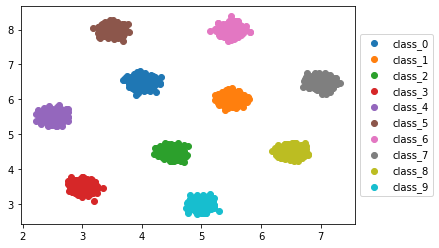

In [181]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [182]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [183]:
np.unique(bg_idx).shape

(3513,)

In [184]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [185]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-3.94054906e-15, -1.42341147e-15]]),
 array([[-0.02477713,  0.03899959]]))

In [186]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [187]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[0.86429775, 0.8750994 ]]))

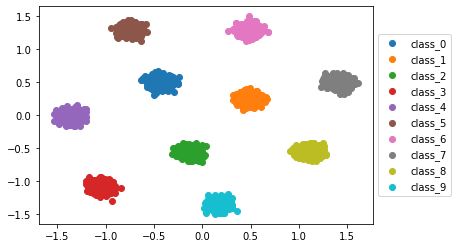

In [188]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [189]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [190]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)

a = []
for i in range(m):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
background 9 present at 2
background 3 present at 3
background 5 present at 4
background 7 present at 5
background 6 present at 6
background 5 present at 7
background 3 present at 8
background 5 present at 9
background 4 present at 10
background 7 present at 11
background 4 present at 12
background 3 present at 13
background 9 present at 14
background 6 present at 15
background 6 present at 16
background 3 present at 17
background 3 present at 18
background 5 present at 19
background 4 present at 20
background 4 present at 21
background 9 present at 22
background 8 present at 23
background 3 present at 24
background 7 present at 25
background 6 present at 26
background 8 present at 27
background 3 present at 28
background 7 present at 29
background 8 present at 30
background 7 present at 31
background 7 present at 32
background 5 present at 33
background 9 present at 34
background 6 present at 35
background 4 present at 36
background 

In [191]:
np.reshape(a,(2*m,1))

array([[-7.52221282e-01],
       [ 1.29671369e+00],
       [ 4.26769159e-01],
       [ 1.30247133e+00],
       [ 1.24551959e-01],
       [-1.40721568e+00],
       [-9.92591187e-01],
       [-1.18031499e+00],
       [-7.71792914e-01],
       [ 1.25941783e+00],
       [ 1.29283021e+00],
       [ 5.05091505e-01],
       [ 5.22396250e-01],
       [ 1.29681995e+00],
       [-7.71792914e-01],
       [ 1.25941783e+00],
       [-1.04309579e+00],
       [-1.06965303e+00],
       [-7.95603446e-01],
       [ 1.29466872e+00],
       [-1.23063037e+00],
       [-8.09254903e-03],
       [ 1.44574202e+00],
       [ 5.99158358e-01],
       [-1.44403474e+00],
       [ 4.54412350e-02],
       [-1.06808318e+00],
       [-1.04600257e+00],
       [ 2.07195375e-01],
       [-1.41318481e+00],
       [ 4.88129706e-01],
       [ 1.27559279e+00],
       [ 5.26188354e-01],
       [ 1.22472122e+00],
       [-9.63519345e-01],
       [-1.06748963e+00],
       [-1.12850086e+00],
       [-1.11163153e+00],
       [-8.6

In [192]:

mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [193]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images.shape

(4000, 1000)

In [194]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((4000, 1000),
 array([ 1.26013674e+00, -5.51913618e-01,  4.77632906e-01,  1.25059329e+00,
         5.42307052e-01,  1.29438001e+00, -1.30547943e+00, -8.37910017e-02,
         1.10227457e+00, -5.56590401e-01,  1.44996512e+00,  5.26308973e-01,
         1.86354734e-01, -1.38666417e+00, -1.04928029e+00, -1.12467272e+00,
        -7.88733214e-01,  1.29405413e+00,  1.84567463e-01, -1.32037523e+00,
         1.23422877e-01, -1.33506830e+00, -1.38697545e+00,  8.10406759e-03,
         5.41318744e-01,  1.22618666e+00,  4.75293110e-01,  1.35411842e+00,
         1.74118890e-01, -1.37819640e+00, -9.94579337e-01, -1.16020706e+00,
        -1.15891128e+00, -1.08140978e+00,  5.12115619e-01,  1.32352332e+00,
         5.52207675e-01,  1.32050992e+00,  1.08191989e-01, -1.26074103e+00,
        -1.09829769e+00, -1.13051010e+00, -1.32539091e+00, -5.31357437e-02,
        -1.05163019e+00, -1.01348995e+00,  5.27791381e-01,  1.38226347e+00,
        -7.91206380e-01,  1.28165655e+00,  1.35517704e+00,  4.98137160e-0

In [195]:
for j in range(m):
  print(mosaic_list_of_images[0][2*j:2*j+2])
  

[ 1.26013674 -0.55191362]
[0.47763291 1.25059329]
[0.54230705 1.29438001]
[-1.30547943 -0.083791  ]
[ 1.10227457 -0.5565904 ]
[1.44996512 0.52630897]
[ 0.18635473 -1.38666417]
[-1.04928029 -1.12467272]
[-0.78873321  1.29405413]
[ 0.18456746 -1.32037523]
[ 0.12342288 -1.3350683 ]
[-1.38697545  0.00810407]
[0.54131874 1.22618666]
[0.47529311 1.35411842]
[ 0.17411889 -1.3781964 ]
[-0.99457934 -1.16020706]
[-1.15891128 -1.08140978]
[0.51211562 1.32352332]
[0.55220767 1.32050992]
[ 0.10819199 -1.26074103]
[-1.09829769 -1.1305101 ]
[-1.32539091 -0.05313574]
[-1.05163019 -1.01348995]
[0.52779138 1.38226347]
[-0.79120638  1.28165655]
[1.35517704 0.49813716]
[-1.08665573 -1.09010415]
[1.43215209 0.51899896]
[ 1.17352851 -0.532011  ]
[-1.16052601 -1.08896392]
[1.25063632 0.55490042]
[-0.72108166  1.29521315]
[-1.00259368 -1.06012338]
[-1.42661154  0.06403798]
[-1.32859875 -0.08555843]
[0.39011094 1.28971354]
[0.40222189 1.28409148]
[-0.78448497  1.33251652]
[-1.07960956 -1.155529  ]
[0.42486134 

In [196]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number, m):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.zeros(m) #np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([2], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(m):
      if j == give_pref:
        img = img + mosaic_dataset[i][2*j:2*j+2]*dataset_number/m   #2 is data dim
      else :
        img = img + mosaic_dataset[i][2*j:2*j+2]*(m-dataset_number)/((m-1)*m)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [197]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr_j], mosaic_label[0:tr_j], fore_idx[0:tr_j] , 1, m)


test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr_j : tr_k], mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] , m, m)

number of correct averaging happened for dataset 1 is 2000
the averaging are done as  [ 2.  2.  3.  3.  2.  6.  3.  5.  2.  3.  1.  6.  5.  5.  4.  5.  6.  3.
  5.  3.  1.  3.  5.  5.  4.  4.  4.  2.  6.  3.  8.  2.  1.  2.  4.  3.
  0.  4.  2.  4.  4.  3.  3.  2.  3.  4.  4.  5.  4.  3.  4.  7.  1.  5.
  4.  6.  7.  2.  4.  4.  4.  4.  5.  3.  3.  4. 10.  0.  3.  5.  8.  3.
  5.  4.  5.  1.  4.  8.  7.  3.  9.  6.  3.  6.  5.  3.  8.  5.  3.  4.
  4.  1.  7.  2.  6.  6.  1.  7.  2.  4.  4.  3.  5.  6.  3.  7.  5.  4.
  2.  4.  8.  4.  2.  5.  7.  4.  4.  8.  1.  5.  2.  4.  1.  2.  6.  4.
  3.  3.  6.  1.  3.  6.  5.  1.  3.  4.  3.  2.  3.  3.  1.  1.  1.  8.
  5.  7.  4.  5.  5.  4.  3.  4.  3.  5.  6.  2.  9.  3.  4.  3.  6.  3.
  5.  4.  0.  3.  4.  3.  6.  8.  3.  1.  3.  4.  5.  1.  6.  6.  7.  3.
  5.  2.  5.  6.  3.  4.  5.  3.  2.  6.  6.  2.  7.  6.  5.  4.  5.  5.
  5.  4.  4.  4.  5.  4.  7.  2.  4.  6.  5.  2.  4.  4.  6.  3.  6.  8.
  1.  3.  7.  2.  6.  4.  5.  9.  2.  

In [198]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)
# avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)


test_dataset = torch.stack(test_dataset, axis = 0)
# test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/500')

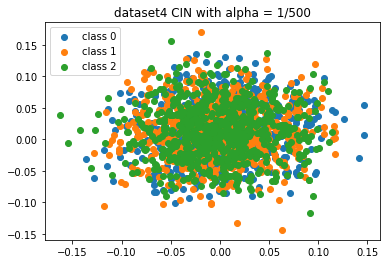

In [199]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

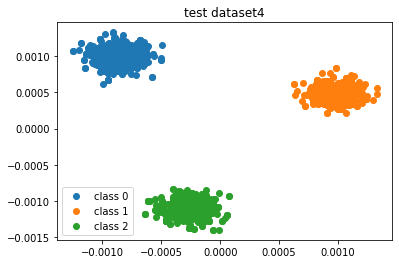

In [200]:
x1 = (test_dataset).numpy() / m
y1 = np.array(labels)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,0], x1[y1==2,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [201]:
test_dataset[0:10]/m

tensor([[-0.0001, -0.0011],
        [-0.0007,  0.0009],
        [ 0.0010,  0.0005],
        [-0.0010,  0.0010],
        [-0.0002, -0.0011],
        [ 0.0010,  0.0008],
        [-0.0006,  0.0011],
        [ 0.0008,  0.0005],
        [-0.0002, -0.0011],
        [-0.0003, -0.0011]], dtype=torch.float64)

In [202]:
test_dataset = test_dataset/m
test_dataset[0:10]

tensor([[-0.0001, -0.0011],
        [-0.0007,  0.0009],
        [ 0.0010,  0.0005],
        [-0.0010,  0.0010],
        [-0.0002, -0.0011],
        [ 0.0010,  0.0008],
        [-0.0006,  0.0011],
        [ 0.0008,  0.0005],
        [-0.0002, -0.0011],
        [-0.0003, -0.0011]], dtype=torch.float64)

In [203]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [204]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([-0.0109,  0.0335], dtype=torch.float64)

In [205]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [206]:
testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [207]:
testdata_11 = MosaicDataset(test_dataset, labels )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [208]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,3)
        # self.linear2 = nn.Linear(50,10)
        # self.linear3 = nn.Linear(10,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = (self.linear1(x))

        return x

In [209]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [210]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [211]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi
    

In [212]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_11]

In [213]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 1.100
epoch: [1] loss: 1.100
epoch: [201] loss: 1.097
epoch: [401] loss: 1.097
epoch: [601] loss: 1.097
epoch: [801] loss: 1.097
Finished Training
Accuracy of the network on the 2000 train images: 35.45 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  709 total  2000
Accuracy of the network on the 2000 test dataset 1: 35.45 %
unique out:  [0 1 2] unique pred:  [1]
correct:  663 total  2000
Accuracy of the network on the 2000 test dataset 2: 33.15 %
--------------------------------------------------------------------------------


In [214]:
%matplotlib inline

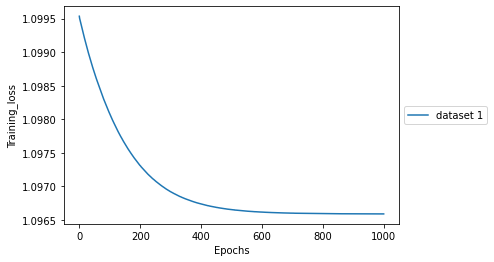

In [215]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))